# Self-Driving Car Engineer Nanodegree
# Project: Detecting vehicles on the road
After the previous project of [detecting lane lines](https://github.com/trort/CarND-Advanced-Lane-Lines), this project aims to detect other vehicles on the road. Identifying other vehicles is important for self-driving cars. And similar algorithms can also be applied to detect the passengers, traffic signs, etc. Similar as the previous project, I will start from processing individual images, and build video processing pipeline based on that.

## Import packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
import pickle
import os
%matplotlib inline

## Build image classifier from the training dataset
A labeled dataset of car images and not car images is downloaded from [here](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/vehicles.zip) and [here](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/non-vehicles.zip) and used to train the classifier. The color space histogram and Histogram of Oriented Gradients (HOG) are used as the training features.

### Preprocess training images into single pickle file
Run this part only once then the raw files can be deleted

In [36]:
###
### SKIP this cell once the raw iamges are pickled
###
image_size = 64
image_depth = 3

vehicle_pickle_name = './training_sets/vehicles.pickle'
if os.path.exists(vehicle_pickle_name):
    print('Vehicle pickle file already exist!')
else:
    vehicle_filenames = glob.glob('./training_sets/vehicles/*/*.png')
    vehicle_dataset = np.ndarray(shape=(len(vehicle_filenames), image_size, image_size, image_depth),
                         dtype=np.float32)
    for i, filename in enumerate(vehicle_filenames):
        image_data = mpimg.imread(filename)
        vehicle_dataset[i, :, :, :] = image_data
        
    with open(vehicle_pickle_name, 'wb') as f:
        pickle.dump(vehicle_dataset, f)
        
non_vehicle_pickle_name = './training_sets/non_vehicles.pickle'
if os.path.exists(non_vehicle_pickle_name):
    print('Non-vehicle pickle file already exist!')
else:
    non_vehicle_filenames = glob.glob('./training_sets/non-vehicles/*/*.png')
    non_vehicle_dataset = np.ndarray(shape=(len(non_vehicle_filenames), image_size, image_size, image_depth),
                         dtype=np.float32)
    for i, filename in enumerate(non_vehicle_filenames):
        image_data = mpimg.imread(filename)
        non_vehicle_dataset[i, :, :, :] = image_data
        
    with open(non_vehicle_pickle_name, 'wb') as f:
        pickle.dump(non_vehicle_dataset, f)
        
print('Pickle files prepared!')

Pickle files prepared!


In [2]:
# load image data from pickle files
vehicle_pickle_name = './training_sets/vehicles.pickle'
with open(vehicle_pickle_name, 'rb') as f:
    vehicle_dataset = pickle.load(f)

non_vehicle_pickle_name = './training_sets/non_vehicles.pickle'
with open(non_vehicle_pickle_name, 'rb') as f:
    non_vehicle_dataset = pickle.load(f)

vehicle examples:


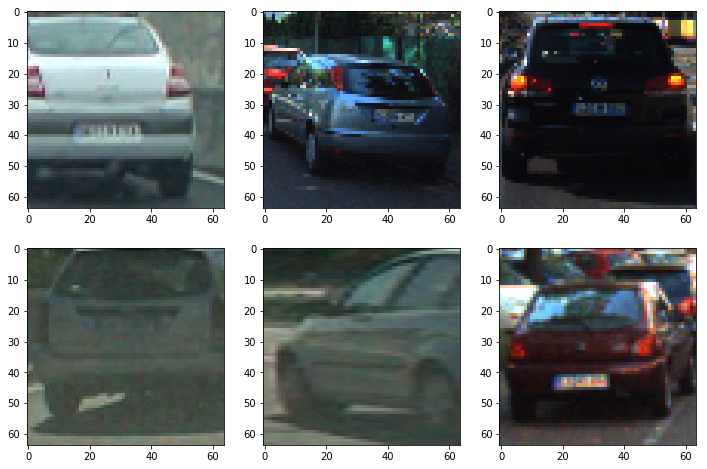

non vehicle examples:


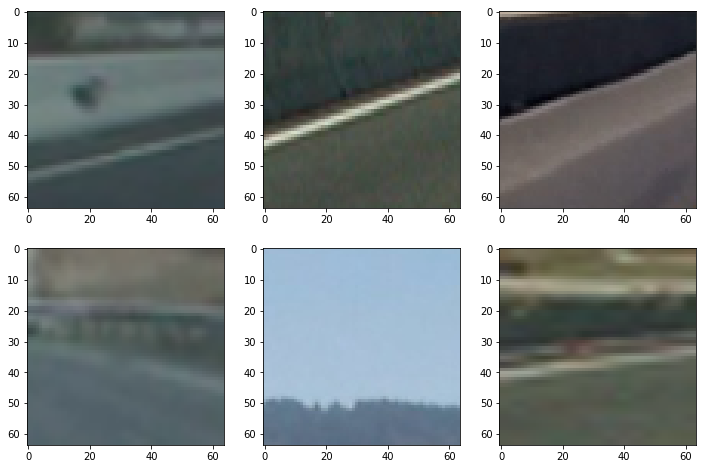

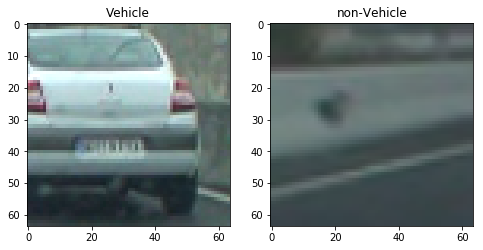

In [19]:
# preview a random set of vehicle and non vehicle images
print('vehicle examples:')
vehicle_preview_idx = np.random.choice(len(vehicle_dataset), 6)
f, ax = plt.subplots(2, 3, figsize=(12,8))
for i, idx in enumerate(vehicle_preview_idx):
    img = vehicle_dataset[idx, :, :, :]
    ax[i%2][i//2].imshow(img)
plt.show()
    
print('non vehicle examples:')
non_vehicle_preview_idx = np.random.choice(len(non_vehicle_dataset), 6)
f, ax = plt.subplots(2, 3, figsize=(12,8))
for i, idx in enumerate(non_vehicle_preview_idx):
    img = non_vehicle_dataset[idx, :, :, :]
    ax[i%2][i//2].imshow(img)
plt.show()

f, (ax0, ax1) = plt.subplots(1,2, figsize=(8,4))
ax0.imshow(vehicle_dataset[vehicle_preview_idx[0],:,:,:])
ax0.set_title('Vehicle')
ax1.imshow(non_vehicle_dataset[non_vehicle_preview_idx[0],:,:,:])
ax1.set_title('non-Vehicle')
plt.show()

vehicle examples:


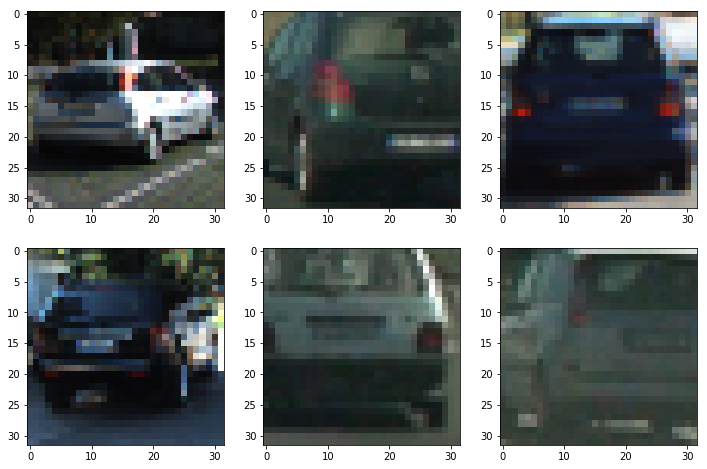

non vehicle examples:


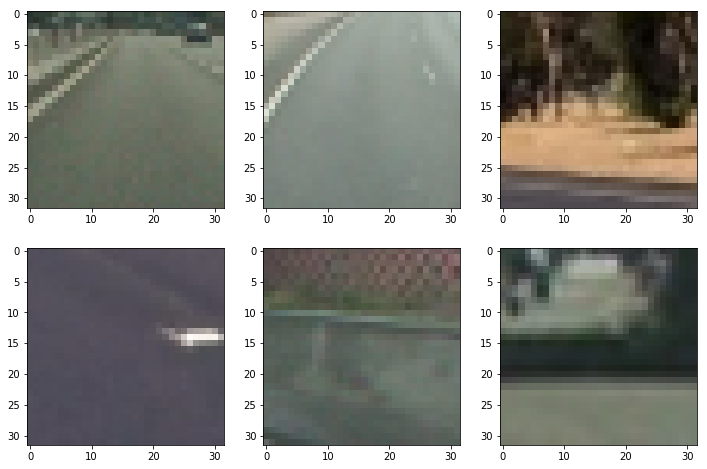

In [57]:
# explore the minimum size to possibly identify vehicle or not
# 32 x 32 is definitely enough, 16 x 16 might be ok
dsize = (32, 32)

print('vehicle examples:')
f, ax = plt.subplots(2, 3, figsize=(12,8))
for i, idx in enumerate(vehicle_preview_idx):
    img = vehicle_dataset[idx, :, :, :]
    img = cv2.resize(img, dsize)
    ax[i%2][i//2].imshow(img)
plt.show()
    
print('non vehicle examples:')
f, ax = plt.subplots(2, 3, figsize=(12,8))
for i, idx in enumerate(non_vehicle_preview_idx):
    img = non_vehicle_dataset[idx, :, :, :]
    img = cv2.resize(img, dsize)
    ax[i%2][i//2].imshow(img)
plt.show()

### Preview test images in different color spaces

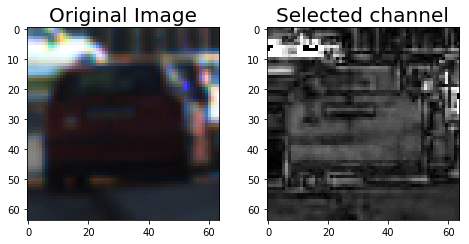

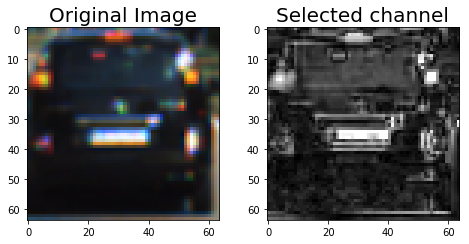

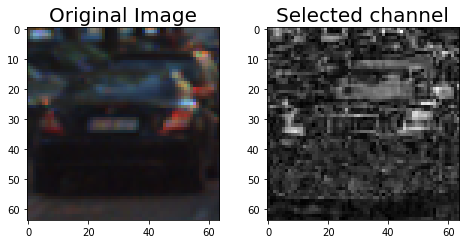

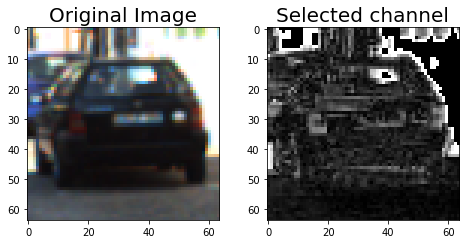

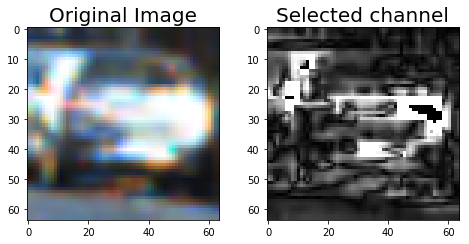

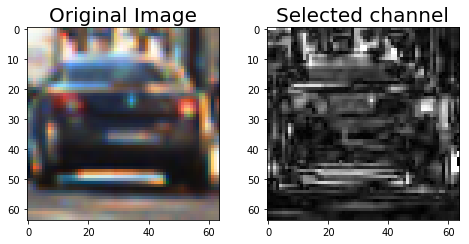

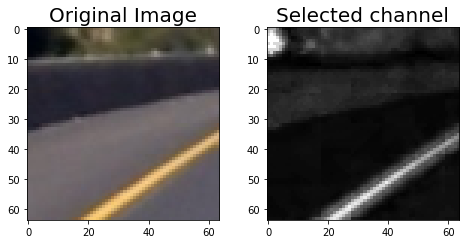

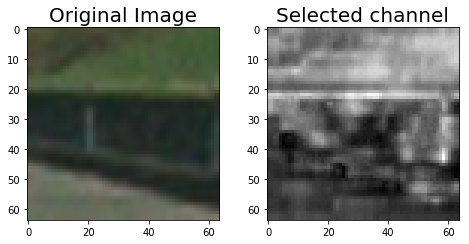

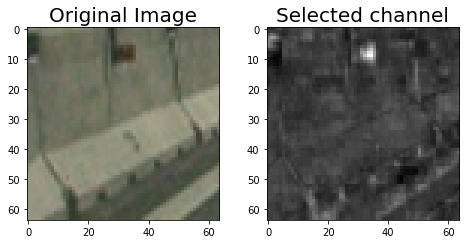

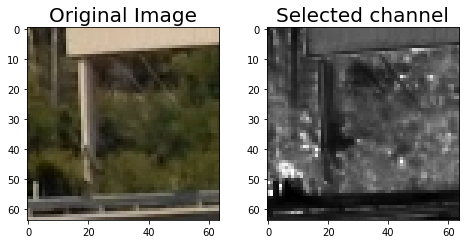

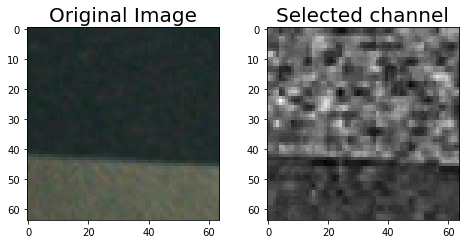

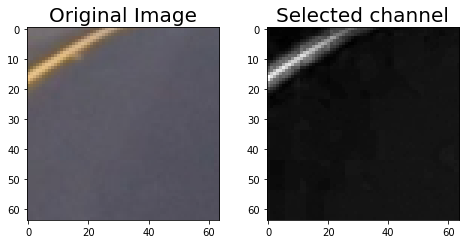

In [4]:
# play with color spaces
# cars tend to have high S value
preview_images = np.concatenate((vehicle_dataset[vehicle_preview_idx, :, :, :],
                                 non_vehicle_dataset[non_vehicle_preview_idx, :, :, :]))

for img in preview_images:
    #img = vehicle_dataset[idx, :, :, :]
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    channel = hls[:, :, 2]

    # Plot the result
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3))
    f.tight_layout()
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=20)
    ax2.imshow(channel, cmap = 'gray')
    ax2.set_title('Selected channel', fontsize=20)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    plt.show()

### Extract color space histogram features

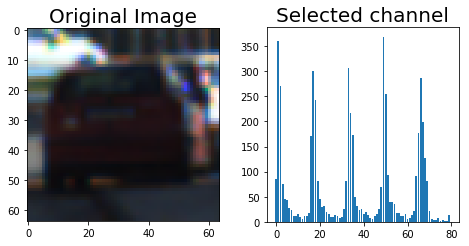

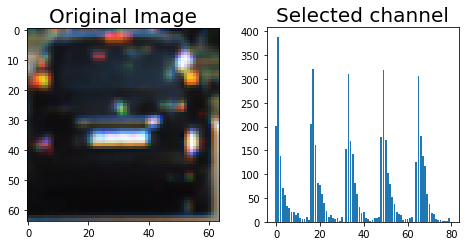

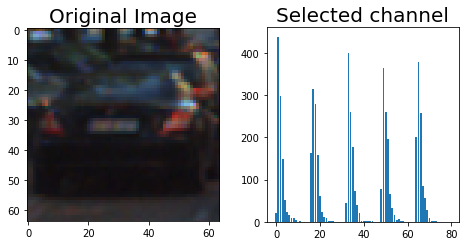

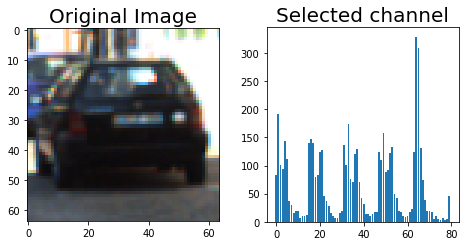

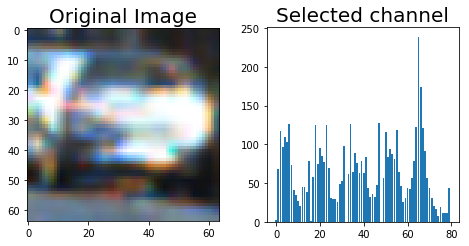

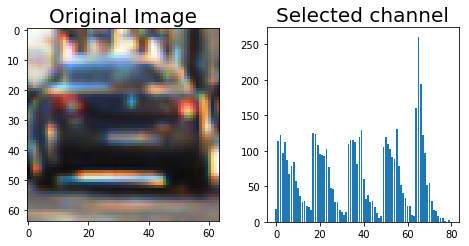

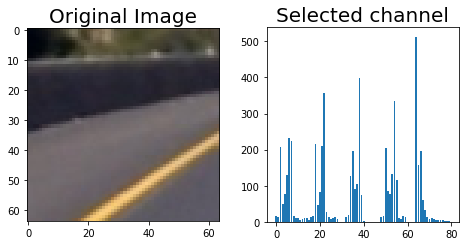

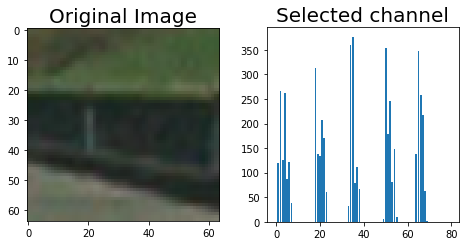

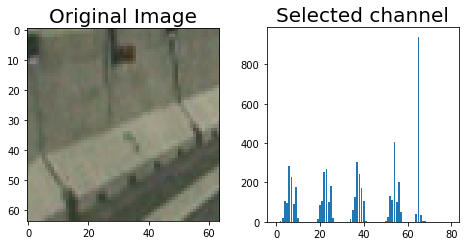

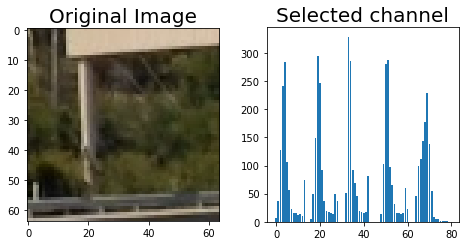

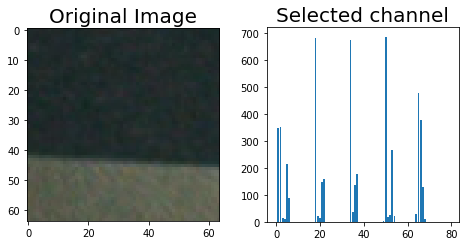

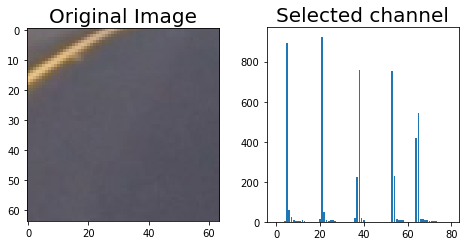

In [5]:
# function to extract color space features after resizing
def get_color_hist(img, dsize = (32, 32), nbins=16, bins_range=(0, 1)):
    resized = cv2.resize(img, dsize)
    # Compute the histogram of the RGB channels separately
    rhist = np.histogram(resized[:,:,0], bins=nbins, range=bins_range)
    ghist = np.histogram(resized[:,:,1], bins=nbins, range=bins_range)
    bhist = np.histogram(resized[:,:,2], bins=nbins, range=bins_range)
    # Compute the histogram of the HLS channels, and use the L and S channels
    hls = cv2.cvtColor(resized, cv2.COLOR_RGB2HLS)
    lhist = np.histogram(hls[:,:,1], bins=nbins, range=bins_range)
    shist = np.histogram(hls[:,:,2], bins=nbins, range=bins_range)
    # Generating bin centers
    #bin_edges = rhist[1]
    #bin_centers = (bin_edges[1:]  + bin_edges[:-1])/2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0], lhist[0], shist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

for img in preview_images:
    hist = get_color_hist(img)
    
    # Plot the result
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3))
    f.tight_layout()
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=20)
    ax2.bar(np.arange(len(hist)), hist)
    ax2.set_title('Color histogram', fontsize=20)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    plt.show()

### Extract HOG features

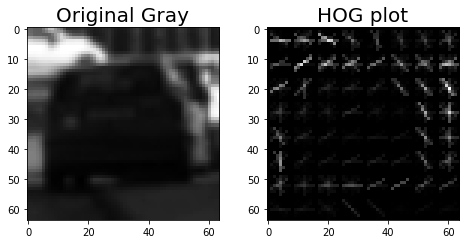

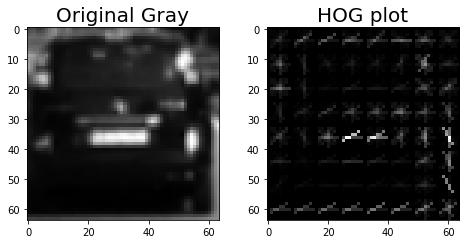

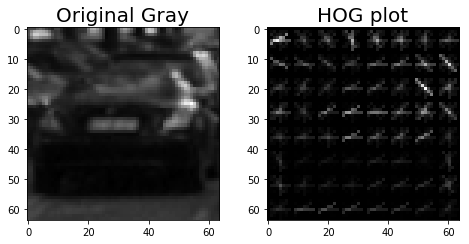

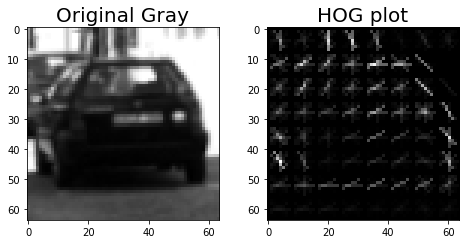

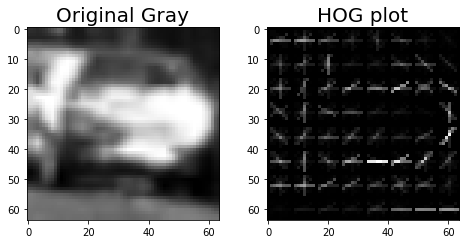

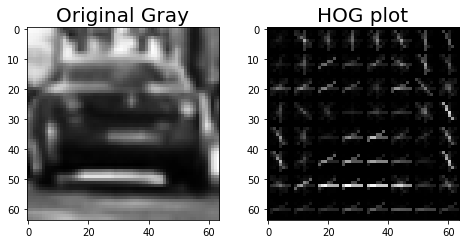

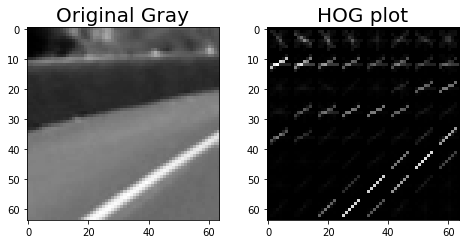

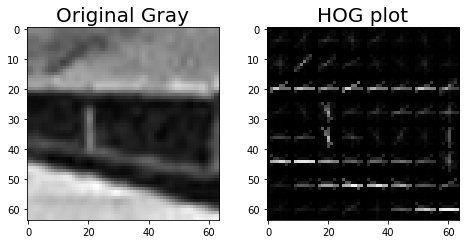

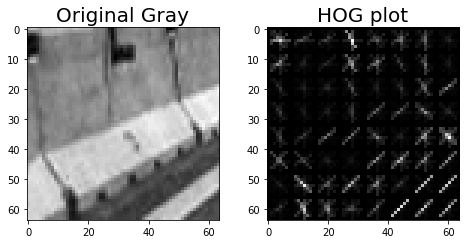

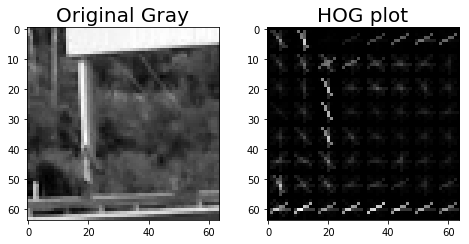

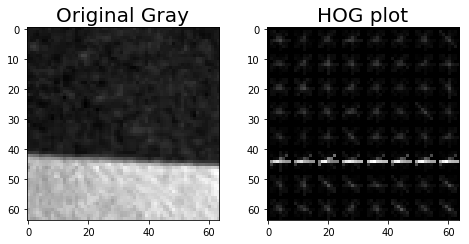

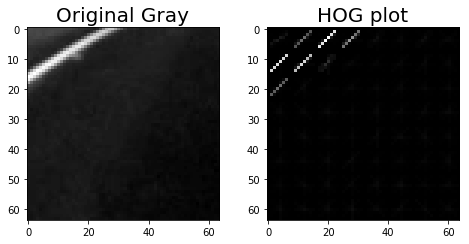

In [20]:
# HOG
from skimage.feature import hog

def get_HOG_features(img, orientations=8, pixels_per_cell=(8, 8), cells_per_block=(2, 2), gray = True):
    if gray:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        features, hog_image = hog(gray, orientations=orientations, 
                                  pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block, 
                                  transform_sqrt=True, visualise=True, feature_vector=True)
        return features, hog_image
    else:
        features = []
        for ch in range(img.shape[-1]):
            channel = img[:, :, ch]
            ch_features = hog(channel, orientations=orientations, 
                                  pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block, 
                                  transform_sqrt=True, visualise=False, feature_vector=True)
            features.append(ch_features)
        return np.concatenate(features)

for img in preview_images:
    features, hog_image = get_HOG_features(img)
    #print(features.shape)
    
    # Plot the result
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3))
    f.tight_layout()
    ax1.imshow(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY), cmap = 'gray')
    ax1.set_title('Original Gray', fontsize=20)
    ax2.imshow(hog_image, cmap = 'gray')
    ax2.set_title('HOG plot', fontsize=20)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    plt.show()

### Feature extractions and normalization

/Users/jiajunluo/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


(12, 4784) (12,)


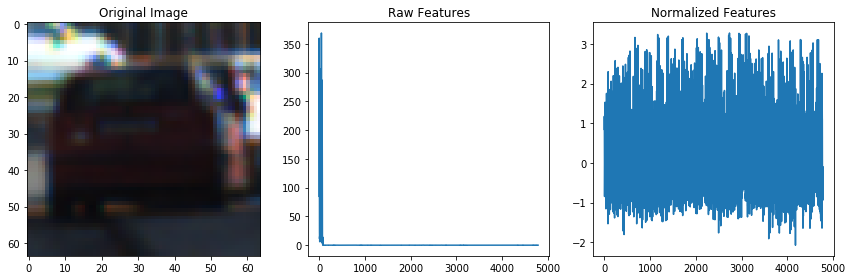

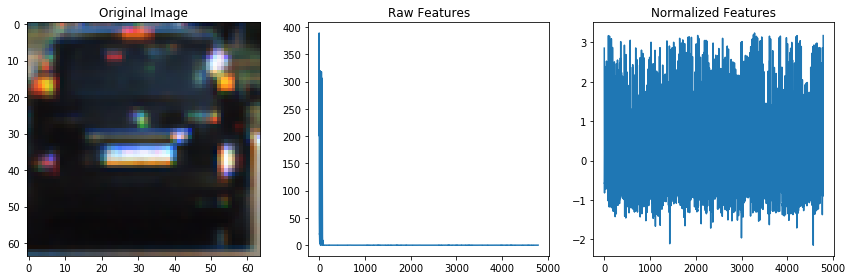

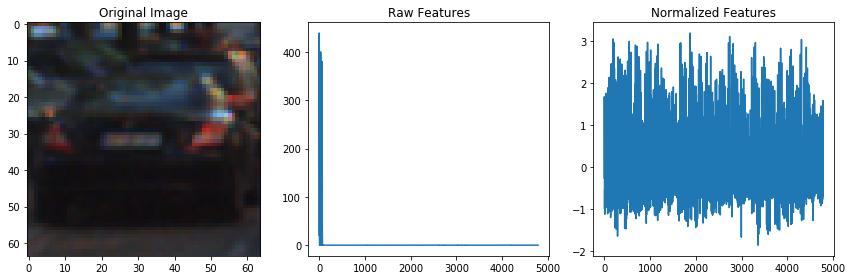

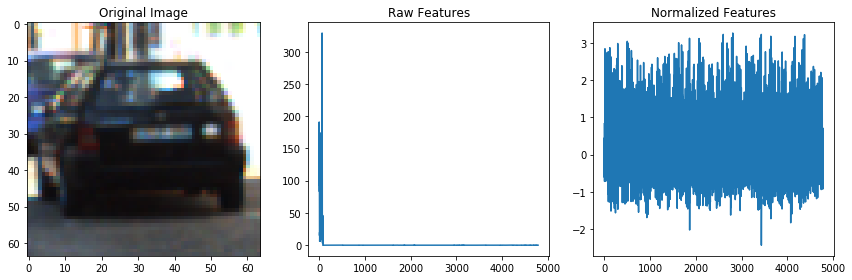

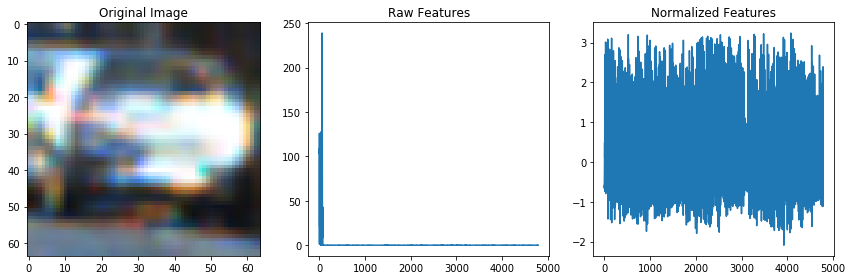

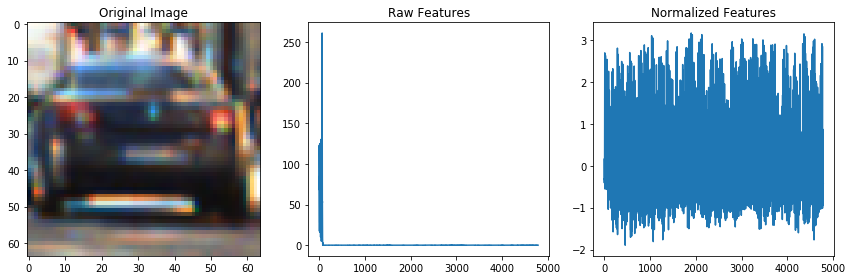

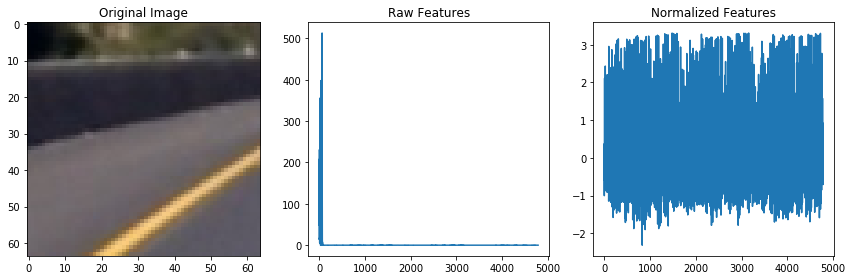

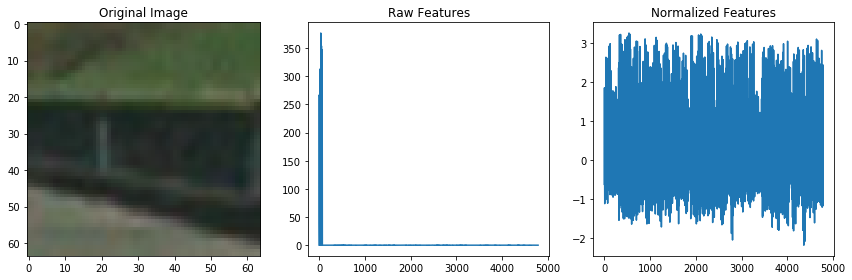

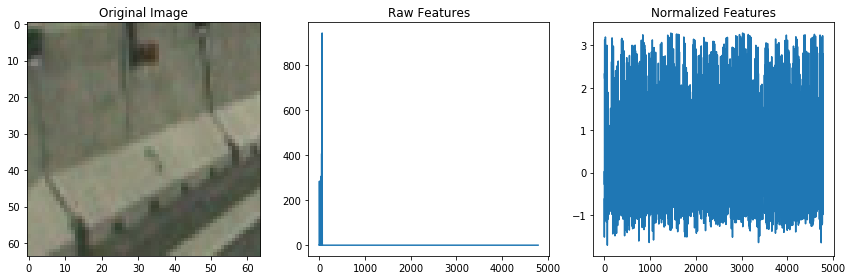

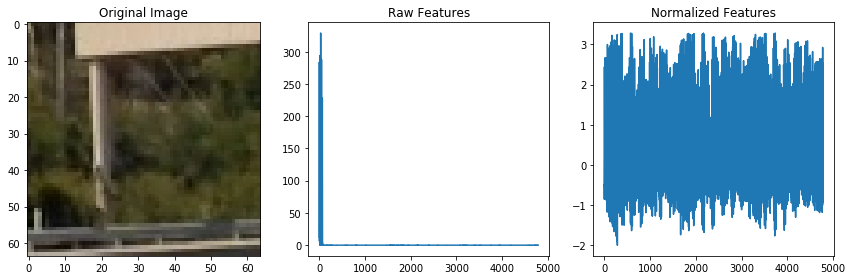

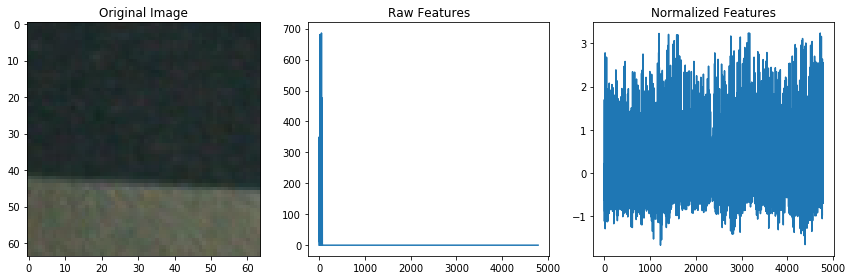

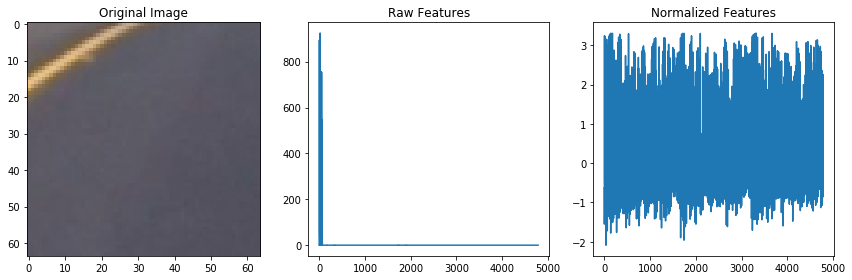

In [7]:
from sklearn.preprocessing import StandardScaler

def extract_features(imgs, dsize = (32, 32), nbins=16, bins_range=(0, 1),
                    orientations=8, pixels_per_cell=(8, 8), cells_per_block=(2, 2),
                    gray = False):
    features = []
    for img in imgs:
        color_features = get_color_hist(img, dsize=dsize, nbins=nbins, bins_range=bins_range)
        hog_features = get_HOG_features(img, orientations=orientations,
                                       pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block,
                                       gray=gray)
        #print(color_features.shape, hog_features.shape)
        #print(np.concatenate((color_features, hog_features)).shape)
        features.append(np.concatenate((color_features, hog_features)))
    return features

# test with preview data
preview_car_features = extract_features(preview_images[:6])
preview_not_car_features = extract_features(preview_images[6:])
preview_X = np.vstack((preview_car_features, preview_not_car_features)).astype(np.float64)
preview_X_scaler = StandardScaler().fit(preview_X)
scaled_preview_X = preview_X_scaler.transform(preview_X)
preview_Y = np.array(([1] * 6 + [0] * 6))
print(scaled_preview_X.shape, preview_Y.shape)

for i, img in enumerate(preview_images):
    fig = plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.imshow(img)
    plt.title('Original Image')
    plt.subplot(132)
    plt.plot(preview_X[i])
    plt.title('Raw Features')
    plt.subplot(133)
    plt.plot(scaled_preview_X[i])
    plt.title('Normalized Features')
    fig.tight_layout()

In [95]:
###
### SKIP this cell when feature data is already prepared
###
# prepare and save all features, labels, and scaler
vehicle_features = extract_features(vehicle_dataset)
non_vehicle_features = extract_features(non_vehicle_dataset)
X = np.vstack((vehicle_features, non_vehicle_features)).astype(np.float64)
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)
Y = np.array(([1] * len(vehicle_dataset) + [0] * len(non_vehicle_dataset)))
print(X.shape, Y.shape)
data_dict = {}
data_dict['features'] = scaled_X
data_dict['labels'] = Y
data_dict['scaler'] = X_scaler
with open('clf_data.pkl', 'wb') as f:
    pickle.dump(data_dict, f)
del X
del scaled_X
del Y

/Users/jiajunluo/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


(17760, 4784) (17760,)


In [8]:
# load training data from files
from sklearn.utils import shuffle

with open('clf_data.pkl', 'rb') as f:
    data_dict = pickle.load(f)

scaled_X = data_dict['features']
Y = data_dict['labels']
X_scaler = data_dict['scaler']
print(scaled_X.shape, Y.shape)
scaled_X, Y = shuffle(scaled_X, Y)

d:\Anaconda2\envs\carnd-term1\lib\site-packages\sklearn\base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.18.1 when using version 0.18.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


(17760, 4784) (17760,)


### Build a classifier

In [6]:
###
### SKIP this cell once the best classifier is saved
###
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.externals import joblib
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators = 100, max_features = 0.1, max_depth = 10, 
                             min_samples_split = 0.0003)

param_test = {'n_estimators':[80, 100, 120, 150],
              'max_features':[0.05, 0.08, 0.1, 0.15],
              'max_depth':[8, 10, 12],
              'min_samples_split':[0.0001, 0.0003, 0.0005]}

rsearch = RandomizedSearchCV(estimator = clf, param_distributions = param_test, n_iter = 20, verbose=5,
                        scoring='accuracy',n_jobs=3,iid=False, cv=3, refit=True)
rsearch.fit(scaled_X, Y)
print(rsearch.cv_results_)
print(rsearch.best_params_)
print(rsearch.best_score_)

classifier = rsearch.best_estimator_

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed: 35.2min
[Parallel(n_jobs=3)]: Done  60 out of  60 | elapsed: 198.1min finished


{'split0_train_score': array([ 0.99839513,  0.99831067,  0.99712814,  0.99087761,  0.99020188,
        0.99586114,  0.9977194 ,  0.99138441,  0.9984796 ,  0.99163781,
        0.99087761,  0.99628347,  0.99560774,  0.99062421,  0.99552327,
        0.99087761,  0.99096207,  0.99586114,  0.99653687,  0.99256694]), 'params': ({'min_samples_split': 0.0003, 'max_features': 0.05, 'max_depth': 12, 'n_estimators': 120}, {'min_samples_split': 0.0001, 'max_features': 0.05, 'max_depth': 12, 'n_estimators': 100}, {'min_samples_split': 0.0003, 'max_features': 0.1, 'max_depth': 12, 'n_estimators': 120}, {'min_samples_split': 0.0005, 'max_features': 0.08, 'max_depth': 8, 'n_estimators': 150}, {'max_features': 0.08, 'max_depth': 8, 'min_samples_split': 0.0001, 'n_estimators': 150}, {'max_features': 0.08, 'n_estimators': 120, 'max_depth': 10, 'min_samples_split': 0.0001}, {'max_features': 0.15, 'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 0.0001}, {'max_features': 0.15, 'n_estimators': 80,

##### 3-fold CV parameter search result
Random Forest accuracy: 

n_estimator: (max_features = 0.3, max_depth = 10, min_samples_split = 0.01)
50 => 0.96869341; 
100 => 0.97021373; 
200 => 0.96914392; 

max_features: (n_estimator = 100, max_depth = 10, min_samples_split = 0.01)
0.1 => 0.97263519;
0.2 => 0.97179047;
0.3 => 0.97021373;
0.35 => 0.97032672;
0.4 => 0.9693696;

max_depth: (n_estimator = 100, max_features = 0.1, min_samples_split = 0.01)
2 => 0.87364901;
4 => 0.94690338;
6 => 0.96407681;
8 => 0.96953834;
10 => 0.97263519;

min_samples_split: (n_estimator = 100, max_features = 0.1, max_depth = 10)
0.0003 => 0.97882887;
0.001 => 0.97775903;
0.003 => 0.97646405;
0.01 => 0.97263519;
0.03 => 0.96216232;

##### Final parameter set
{'max_features': 0.15, 'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 0.0001}
0.980518027152

In [7]:
# save the model
clf_model = {'classifier':classifier, 'scaler':X_scaler}
with open('clf_model.pkl', 'wb') as f:
    pickle.dump(clf_model, f)

/Users/jiajunluo/anaconda/envs/carnd-term1/lib/python3.5/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.18.2 when using version 0.18.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/jiajunluo/anaconda/envs/carnd-term1/lib/python3.5/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.18.2 when using version 0.18.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/jiajunluo/anaconda/envs/carnd-term1/lib/python3.5/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.18.2 when using version 0.18.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


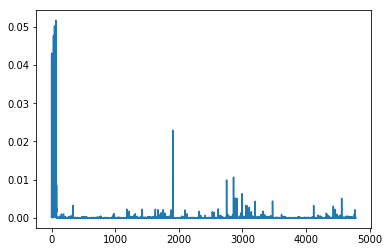

In [8]:
# load the model
with open('clf_model.pkl', 'rb') as f:
    clf_model = pickle.load(f)
    
classifier = clf_model['classifier']
X_scaler = clf_model['scaler']
plt.plot(classifier.feature_importances_)

### Slide window search
Slide windows and predict for each window

/Users/jiajunluo/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


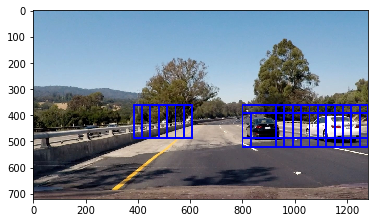

In [9]:
# slide window functions
def draw_boxes(img, bboxes, color=(0, 0, 1.0), thick=6):
    imcopy = np.copy(img)
    for bbox in bboxes:
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    return imcopy

def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    window_size=(32, 32), xy_overlap=(0.5, 0.5)):
    window_list = []
    if x_start_stop == [None, None]:
        x_start_stop = [0, img.shape[1]]
    if y_start_stop == [None, None]:
        y_start_stop = [img.shape[0] // 2, img.shape[0]]
    for x in range(x_start_stop[0], x_start_stop[1] - window_size[0] + 1, int(window_size[0] * (1-xy_overlap[0]))):
        for y in range(y_start_stop[0], y_start_stop[1] - window_size[1] + 1, int(window_size[1] * (1-xy_overlap[1]))):
            window_list.append(((x,y),(x+window_size[0], y+window_size[1])))
    return window_list

def predict_windows(img, window_list, clf, X_scaler = None, dsize = (64, 64)):
    window_imgs = []
    for window in window_list:
        window_imgs.append(cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], dsize))
    window_features = extract_features(window_imgs)
    #print(len(window_features),window_features[0].shape)
    if X_scaler is not None:
        window_features = X_scaler.transform(window_features)
    window_predictions = clf.predict(window_features)
    ans_list = []
    for window, ret in zip(window_list, window_predictions):
        if ret == 1:
            ans_list.append(window)
    return ans_list

def find_vehicle_window_list(img, clf, X_scaler, x_start_stop=[None, None], y_start_stop=[None, None], 
                    window_size=(128, 128), xy_overlap=(0.75, 0.75)):
    '''
    return list of possible car windows by extracting then predicting window by window (less efficient)
    '''
    window_list = slide_window(img, x_start_stop, y_start_stop, window_size, xy_overlap)
    car_windows = predict_windows(img, window_list, clf, X_scaler=X_scaler)
    return car_windows

image = mpimg.imread('./test_images/test4.jpg')
image = np.float32(image/255.0)
car_window_list = find_vehicle_window_list(image, classifier, X_scaler=X_scaler)
patched_img = draw_boxes(image, car_window_list)
plt.imshow(patched_img)

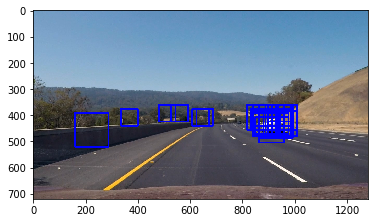

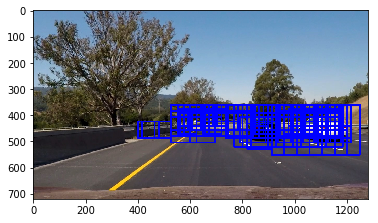

In [30]:
def find_vehicle_windows(img, clf, X_scaler = None, x_start_stop=[None, None], y_start_stop=[None, None], 
                    window_size=(64, 64), xy_overlap=(0.5, 0.5)):
    if x_start_stop == [None, None]:
        x_start_stop = [0, img.shape[1]]
    if y_start_stop == [None, None]:
        y_start_stop = [img.shape[0] // 2, img.shape[0]]
    img_of_interest = img[y_start_stop[0]:y_start_stop[1], x_start_stop[0]:x_start_stop[1], :]
    
    # get all hist features
    hist_features = []
    hist_default_size = (32, 32)
    img_hist = cv2.resize(img_of_interest, 
                        (img_of_interest.shape[1] * hist_default_size[0] // window_size[0],
                         img_of_interest.shape[0] * hist_default_size[1] // window_size[1]))
    img_hist_hls = cv2.cvtColor(img_hist, cv2.COLOR_RGB2HLS)
    nbins=16
    bins_range=(0, 1)
    for x in range(0, img_hist.shape[1]+1-hist_default_size[0], int(hist_default_size[0] * (1-xy_overlap[0]))):
        for y in range(0, img_hist.shape[0]+1-hist_default_size[1], int(hist_default_size[1] * (1-xy_overlap[1]))):
            rhist = np.histogram(img_hist[y:y+hist_default_size[1],x:x+hist_default_size[0],0], bins=nbins, range=bins_range)
            ghist = np.histogram(img_hist[y:y+hist_default_size[1],x:x+hist_default_size[0],1], bins=nbins, range=bins_range)
            bhist = np.histogram(img_hist[y:y+hist_default_size[1],x:x+hist_default_size[0],2], bins=nbins, range=bins_range)
            lhist = np.histogram(img_hist_hls[y:y+hist_default_size[1],x:x+hist_default_size[0],1], bins=nbins, range=bins_range)
            shist = np.histogram(img_hist_hls[y:y+hist_default_size[1],x:x+hist_default_size[0],2], bins=nbins, range=bins_range)
            hist_features.append(np.concatenate((rhist[0], ghist[0], bhist[0], lhist[0], shist[0])))
    
    # get all hog features
    hog_default_size = (64, 64)
    img_hog = cv2.resize(img_of_interest, 
                        (img_of_interest.shape[1] * hog_default_size[0] // window_size[0],
                         img_of_interest.shape[0] * hog_default_size[1] // window_size[1]))
    
    hog_features = []
    hogmap0 = hog(img_hog[:,:,0], orientations=8, 
                                  pixels_per_cell=(8,8), cells_per_block=(2,2), 
                                  transform_sqrt=True, visualise=False, feature_vector=False)
    hogmap1 = hog(img_hog[:,:,1], orientations=8, 
                                  pixels_per_cell=(8,8), cells_per_block=(2,2), 
                                  transform_sqrt=True, visualise=False, feature_vector=False)
    hogmap2 = hog(img_hog[:,:,2], orientations=8, 
                                  pixels_per_cell=(8,8), cells_per_block=(2,2), 
                                  transform_sqrt=True, visualise=False, feature_vector=False)
    for x in range(0, img_hog.shape[1]+1-hog_default_size[0], int(hog_default_size[0] * (1-xy_overlap[0]))):
        for y in range(0, img_hog.shape[0]+1-hog_default_size[1], int(hog_default_size[1] * (1-xy_overlap[1]))):
            hog0 = hogmap0[(y//8):(y//8)+7, (x//8):(x//8)+7, :, :, :].ravel()
            hog1 = hogmap1[(y//8):(y//8)+7, (x//8):(x//8)+7, :, :, :].ravel()
            hog2 = hogmap2[(y//8):(y//8)+7, (x//8):(x//8)+7, :, :, :].ravel()
            hog_features.append(np.concatenate((hog0, hog1, hog2)))
    
    hist_features = np.vstack(hist_features)
    hog_features = np.vstack(hog_features)
    #print(hist_features.shape, hog_features.shape)
    window_features = np.hstack((hist_features, hog_features))
    #print(all_features.shape)
    
    # get list of window coordinates
    window_list = []
    for x in range(x_start_stop[0], x_start_stop[1] - window_size[0] + 1, int(window_size[0] * (1-xy_overlap[0]))):
        for y in range(y_start_stop[0], y_start_stop[1] - window_size[1] + 1, int(window_size[1] * (1-xy_overlap[1]))):
            window_list.append(((x,y),(x+window_size[0], y+window_size[1])))
            
    if X_scaler is not None:
        window_features = X_scaler.transform(window_features)
    window_predictions = clf.predict(window_features)
    ans_list = []
    for window, ret in zip(window_list, window_predictions):
        if ret == 1:
            ans_list.append(window)
    return ans_list
    
image = mpimg.imread('./test_images/test3.jpg')
image = np.float32(image/255.0)
search_window_sizes = [64, 96, 128, 192]
car_window_list = []
for window_size in search_window_sizes:
    car_window_list.extend(find_vehicle_windows(image, classifier, X_scaler=X_scaler, 
                                       window_size=(window_size,window_size), xy_overlap=(0.75, 0.75)) )
patched_img = draw_boxes(image, car_window_list)
plt.imshow(patched_img)
plt.show()

image = mpimg.imread('./test_images/test6.jpg')
image = np.float32(image/255.0)
search_window_sizes = [64, 96, 128, 192]
car_window_list = []
for window_size in search_window_sizes:
    car_window_list.extend(find_vehicle_windows(image, classifier, X_scaler=X_scaler, 
                                       window_size=(window_size,window_size), xy_overlap=(0.75, 0.75)) )
patched_img = draw_boxes(image, car_window_list)
plt.imshow(patched_img)
plt.show()

### Heatmap method to identify the boundary of car area

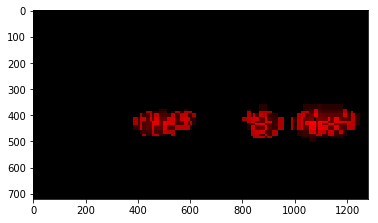

In [36]:
# get heapmap of predictions
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes, add heat +1
    for box in bbox_list:
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    return heatmap

image = mpimg.imread('./test_images/test4.jpg')
image = np.float32(image/255.0)

final_heatmap = np.zeros(image.shape[:2])
search_window_sizes = [64, 96, 128, 192]
for window_size in search_window_sizes:
    car_window_list = find_vehicle_windows(image, classifier, X_scaler=X_scaler, 
                                       window_size=(window_size, window_size), xy_overlap=(0.75, 0.75))
    heatmap = np.zeros(image.shape[:2])
    heatmap = add_heat(heatmap, car_window_list)
    heatmap = apply_threshold(heatmap, 3)
    final_heatmap += heatmap
final_heatmap = apply_threshold(final_heatmap, 10)
plt.imshow(np.dstack(((final_heatmap * 255.0 / np.max(final_heatmap)), np.zeros_like(final_heatmap), np.zeros_like(final_heatmap))))

3


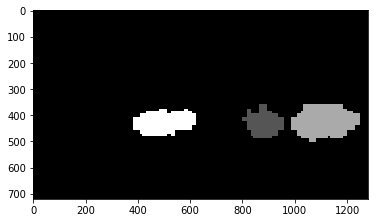

In [37]:
# group hot pixels in heatmap
from scipy.ndimage.measurements import label
#label_structure = np.ones((3,3))
labelmap, nlabels = label(final_heatmap)#, structure = label_structure)
print(nlabels)
plt.imshow(labelmap, cmap='gray')

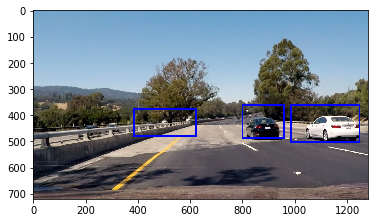

In [38]:
# draw boxes around possible cars
def draw_labeled_bboxes(img, labelmap, nlabels):
    # Iterate through all labels
    bboxes = []
    for car_number in range(1, nlabels+1):
        nonzero = (labelmap == car_number).nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        bboxes.append(bbox)
    patched_img = draw_boxes(img, bboxes)
    return patched_img

patched_img = draw_labeled_bboxes(image, labelmap, nlabels)
plt.imshow(patched_img)

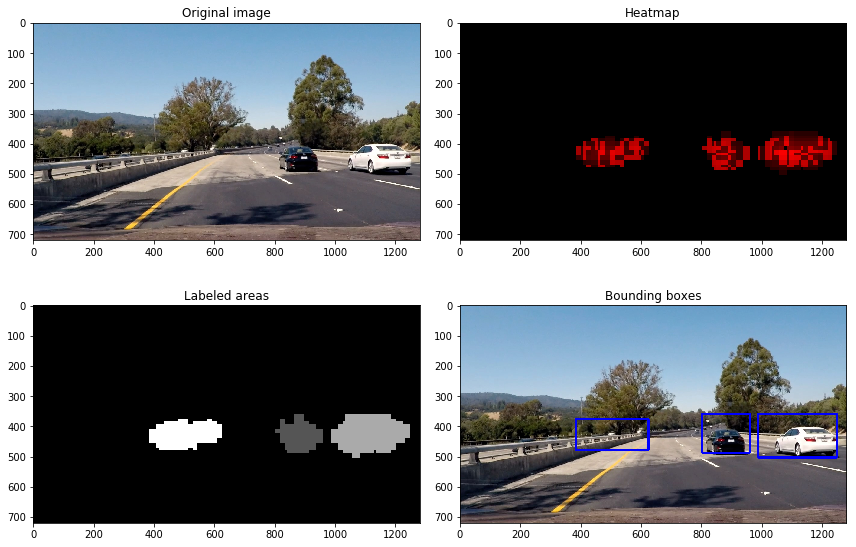

In [39]:
fig = plt.figure(figsize=(12,8))
plt.subplot(221)
plt.imshow(image)
plt.title('Original image')
plt.subplot(222)
plt.imshow(np.dstack(((final_heatmap * 255.0 / np.max(final_heatmap)), 
                      np.zeros_like(final_heatmap), 
                      np.zeros_like(final_heatmap))))
plt.title('Heatmap')
plt.subplot(223)
plt.imshow(labelmap, cmap='gray')
plt.title('Labeled areas')
plt.subplot(224)
plt.imshow(patched_img)
plt.title('Bounding boxes')

fig.tight_layout()

### Video process pipeline

In video process, it is possible to use previous frames to reduce false positives and false negatives in the prediction.

In [14]:
from moviepy.editor import VideoFileClip

class HeatmapHistory():
    def __init__(self):
        from collections import deque
        self.frame_window = 10
        self.recent = deque([], maxlen = self.frame_window)
        
    def get_heatmap(self):
        if len(self.recent) > 0:
            return np.sum(np.dstack(self.recent), axis = 2)
        else:
            return None
    
    def add_new_frame(self, new_heatmap):
        if new_heatmap is not None:
            self.recent.append(new_heatmap)
            
history = HeatmapHistory()

def process_image(image, history = history):
    image = np.float32(image/255.0)
    frame_heatmap = np.zeros(image.shape[:2])
    
    # search in image
    search_window_sizes = [64, 96, 128, 192]
    for window_size in search_window_sizes:
        car_window_list = find_vehicle_windows(image, classifier, X_scaler=X_scaler, 
                                           window_size=(window_size, window_size), xy_overlap=(0.75, 0.75))
        heatmap = np.zeros(image.shape[:2])
        heatmap = add_heat(heatmap, car_window_list)
        heatmap = apply_threshold(heatmap, 2)
        frame_heatmap += heatmap
        
    # heatmap with recent frames
    history.add_new_frame(frame_heatmap)
    final_heatmap = apply_threshold(history.get_heatmap(), 12*len(history.recent))
    
    # draw boxes for cars
    labelmap, nlabels = label(final_heatmap)
    patched_img = draw_labeled_bboxes(image, labelmap, nlabels)
    return patched_img * 255.0
    '''
    return np.hstack((patched_img * 255.0, 
            np.dstack(((final_heatmap * 255.0 / np.max(final_heatmap)), 
                       np.zeros_like(final_heatmap), 
                       np.zeros_like(final_heatmap))) ))
    '''

In [15]:
history = HeatmapHistory()
test_video = 'test_video.mp4'
project_video = 'project_video.mp4'
#clip = VideoFileClip(test_video)
clip = VideoFileClip(project_video)#.subclip(48,52)
#output_video = 'test_video_output.mp4'
output_video = 'project_video_output.mp4'
out_clip = clip.fl_image(process_image)
%time out_clip.write_videofile(output_video, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [48:07<00:02,  2.31s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 42min 32s, sys: 5min 38s, total: 48min 11s
Wall time: 48min 8s
